In [144]:
import os
import sys
import glob
import scipy
import skbio
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style('whitegrid')
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42

from IPython.display import display, HTML
import tRep

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 50
pd.options.display.max_rows = 200

### Load relevant tables

In [145]:
Ndb = pd.read_csv('/data/viral_genome_analysis/tables/IS_outputs/Wastewater_DeltaCoverage_All_Viral_Genomes_v2b_SetMinBreadth.csv')
Ndb_raw = pd.read_csv('/data/viral_genome_analysis/tables/IS_outputs/Wastewater_DeltaCoverage_All_Viral_Genomes_v2_AddRelativeAbundance.csv')
RMdb = pd.read_csv('/data/viral_genome_analysis/tables/IS_outputs/Wastewater_ReadMapping_All_Viral_Genomes_v1.csv')

Gdb = pd.read_csv('/data/viral_genome_analysis/tables/metadata/viral_name_df.csv')
Rdb = pd.read_csv('/data/viral_genome_analysis/tables/metadata/waster_water_readDepths_formatted.csv')
Mdb = pd.read_csv('/data/viral_genome_analysis/tables/metadata/sample_metadata_v2_sample_name_adjusted.csv')

In [146]:
print(len(Ndb['sample'].unique()))
print(len(Ndb_raw['sample'].unique()))
print(len(RMdb['sample'].unique()))

34
34
34


### Examine inStrain profile read filtering

In [147]:
rdb = RMdb.copy()

rdb_simple = rdb[[ 'sample', 'core','subgroup','unfiltered_reads', 'filtered_pairs', 'unfiltered_pairs',
                   'pass_pairing_filter', 'pass_min_read_ani','pass_max_insert', 'pass_min_insert', 
                   'mean_mapq_score', 'pass_min_mapq']]
rdb_simple['perc_pass_min_mapq (%)'] = [round(x/y*100,2) for x,y in zip(rdb_simple['pass_min_mapq'],rdb_simple['pass_pairing_filter'])]
rdb_simple.sort_values('perc_pass_min_mapq (%)')

,sample,core,subgroup,unfiltered_reads,filtered_pairs,unfiltered_pairs,pass_pairing_filter,pass_min_read_ani,pass_max_insert,pass_min_insert,mean_mapq_score,pass_min_mapq,perc_pass_min_mapq (%)
26,p630-S1,ILLUMINA,Illumina_enriched,44442,9646,19250,19250,13235.0,19003.0,14617.0,24.888779,12111.0,62.91
21,SQ2,ILLUMINA,Illumina_unenriched,188630,37700,67388,67388,48745.0,65537.0,53148.0,27.304357,45353.0,67.30
20,SQ1,ILLUMINA,Illumina_unenriched,182088,35581,62045,62045,46399.0,60585.0,50389.0,27.653638,42484.0,68.47
23,S_3_6_30_COL_S14,MIGS,MIGS_MOS & COL,33275,9489,15219,15219,11933.0,15154.0,14474.0,28.764505,10885.0,71.52
13,6_02_Sc_S29,MIGS,MIGS_amicon,19227,5356,8872,8872,7037.0,8833.0,8393.0,28.297453,6354.0,71.62
2,5_19_A_S4,MIGS,MIGS_amicon,27313,8235,12926,12926,10659.0,12889.0,12339.0,29.266362,9471.0,73.27
6,5_28_I_S25,MIGS,MIGS_amicon,66690,19995,31436,31436,25935.0,31269.0,29383.0,30.467330,23812.0,75.75
8,630-S1,ILLUMINA,Illumina_unenriched,314509,78763,125337,125337,96115.0,122077.0,111917.0,30.117499,97192.0,77.54
25,p630-N,ILLUMINA,Illumina_enriched,46862,10266,14623,14623,13018.0,14486.0,13576.0,31.781919,11476.0,78.48
7,630-N,ILLUMINA,Illumina_unenriched,294303,86312,125967,125967,100799.0,124769.0,119073.0,30.699120,99942.0,79.34


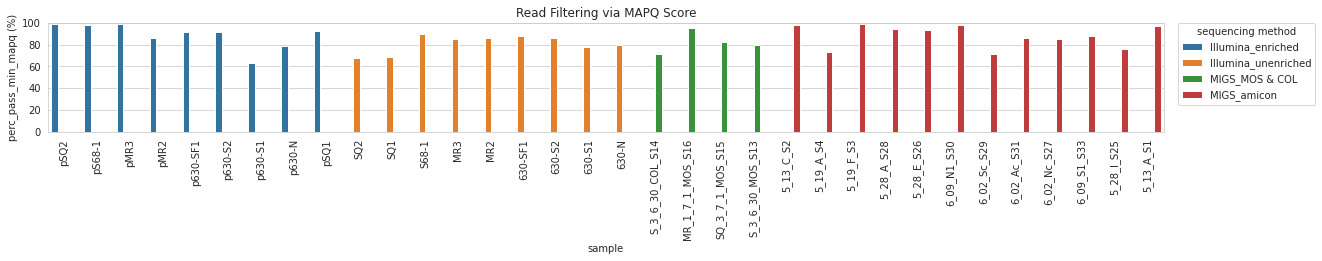

In [148]:
sns.set_style('whitegrid')
plt.figure(figsize=(20,2))
sns.barplot(x='sample',y='perc_pass_min_mapq (%)',data=rdb_simple.sort_values('subgroup'),hue='subgroup')
plt.xticks(rotation=90);
plt.ylim(0,100)
plt.legend(title='sequencing method', bbox_to_anchor=(1.14, 1.045), loc='upper right');
plt.title('Read Filtering via MAPQ Score')
plt.show()

### Extract coronavirus and SARS-CoV2

In [149]:
Ndb_coronavirus = Ndb[Ndb['genome'].str.contains('coronavirus')].reset_index(drop=True)
Ndb_raw_coronavirus = Ndb_raw[Ndb_raw['genome'].str.contains('coronavirus')].reset_index(drop=True)

Ndb_covid19 = Ndb[Ndb['genome'].str.contains('Severe_acute_respiratory_syndrome_coronavirus')].reset_index(drop=True)
Ndb_raw_covid19 = Ndb_raw[Ndb_raw['genome'].str.contains('Severe_acute_respiratory_syndrome_coronavirus')].reset_index(drop=True)


print(len(Ndb_coronavirus['sample'].unique()))
print(len(Ndb_raw_coronavirus['sample'].unique()))
print(len(Ndb_covid19['sample'].unique()))
print(len(Ndb_raw_covid19['sample'].unique()))

24
33
24
32


### Take a look at the IS profile db

In [150]:
cdb = pd.DataFrame(Ndb['genome'].value_counts()).reset_index().rename(columns={'index':'viral_genome_description',\
                                                                               'genome':'num_samples_detected'})\
        .sort_values(['num_samples_detected','viral_genome_description'],ascending=False)

cdb['perc_sample_detected (%)'] = [round(x/34*100,2) for x in cdb['num_samples_detected']]

cdb_raw = pd.DataFrame(Ndb_raw['genome'].value_counts()).reset_index().rename(columns={'index':'viral_genome_description',\
                                                                                        'genome':'num_samples_present'})
cdb_raw['perc_sample_present (%)'] = [round(x/34*100,2) for x in cdb_raw['num_samples_present']]

In [151]:
cdb

,viral_genome_description,num_samples_detected,perc_sample_detected (%)
1,Tomato_brown_rugose_fruit_virus-tax1761477-GCF...,31,91.18
0,Cucumber_green_mottle_mosaic_virus_strain_SH-t...,31,91.18
2,Pepper_mild_mottle_virus_strain_S-tax12239-GCF...,29,85.29
4,uncultured_crAssphage-tax1211417-GCF_000922395...,27,79.41
3,Tomato_mosaic_virus-tax12253-GCF_000853705.1_V...,27,79.41
5,Severe_acute_respiratory_syndrome_coronavirus_...,24,70.59
7,Wuhan_insect_virus_23_strain_WHCCII13263-tax19...,20,58.82
6,Tobacco_mild_green_mosaic_virus-tax12241-GCF_0...,20,58.82
8,Tropical_soda_apple_mosaic_virus-tax327387-GCF...,19,55.88
10,Wenzhou_picorna_like_virus_47_strain_WHCCII111...,17,50.00


### Take a look at sars-cov2

In [152]:
Ndb_covid19

,sample,sample_complete_description,core,method,enrichment,subgroup,genome,length,relative_abundance (%),breadth,coverage,sample_read_bases,sample_reads,popANI_reference,conANI_reference,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,divergent_site_count,reads_unfiltered_reads,nucl_diversity,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,coverage_SEM,breadth_minCov,breadth_expected,nucl_diversity_rarefied,iRep,iRep_GC_corrected,linked_SNV_count,SNV_distance_mean,r2_mean,d_prime_mean,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count
0,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,1.445713,0.704979,2.508344,6107540,82174,0.999827,0.999482,594,662,0.988274,8.0,1377,0.004077,1.0,1.0,1,3.323712,0.019285,0.193860,0.890832,0.000000,NaN,False,NaN,NaN,NaN,NaN,3.0,1.0,1.0,7.0
1,5_13_C_S2,5_13_C_S2_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,6.800861,0.944220,3.716851,1796238,24144,0.999882,0.999882,821,888,0.993680,1.0,1796,0.002344,1.0,1.0,3,2.810959,0.016310,0.283283,0.962446,0.000000,NaN,False,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0
2,5_19_A_S4,5_19_A_S4_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,1.937352,0.997927,14.679631,25431914,343252,0.999930,0.999789,3325,3642,0.991737,88.0,7462,0.002793,1.0,1.0,14,7.519903,0.043633,0.949470,0.999998,0.000000,1.691232,False,36.0,7.583333,0.892179,1.000000,6.0,2.0,2.0,86.0
3,5_19_F_S3,5_19_F_S3_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,14.370810,0.998228,111.809250,24851304,334748,0.999832,0.999765,24053,25013,0.996116,24.0,50686,0.001716,1.0,1.0,111,28.939932,0.167921,0.996121,1.000000,0.001738,1.419377,False,9.0,1.777778,0.732197,0.814462,7.0,5.0,5.0,19.0
4,5_28_A_S28,5_28_A_S28_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,0.023507,0.231616,0.470789,71023874,978422,0.994495,0.994495,115,138,0.984694,3.0,281,0.003955,1.0,1.0,0,1.096183,0.006360,0.018226,0.340126,0.000000,NaN,False,NaN,NaN,NaN,NaN,3.0,3.0,3.0,0.0
5,5_28_E_S26,5_28_E_S26_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,0.145462,0.783333,3.045781,72838764,1009198,0.999559,0.998825,734,870,0.984624,22.0,1824,0.003522,1.0,1.0,2,3.377169,0.019596,0.227669,0.932080,0.000000,NaN,False,NaN,NaN,NaN,NaN,8.0,3.0,3.0,19.0
6,5_28_I_S25,5_28_I_S25_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,0.461996,0.994315,12.160419,89771642,1248062,0.999882,0.999803,2883,3365,0.986816,134.0,6965,0.004601,1.0,1.0,10,9.446424,0.054812,0.849547,0.999978,0.004111,NaN,False,21.0,12.523810,0.709119,1.000000,5.0,3.0,3.0,131.0
7,6_02_Ac_S31,6_02_Ac_S31_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,0.005317,0.135873,0.215029,135654468,1880856,1.000000,1.000000,50,59,0.988460,0.0,118,0.000000,1.0,1.0,0,0.643821,0.003736,0.001605,0.172934,0.000000,NaN,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
8,6_02_Nc_S27,6_02_Nc_S27_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,0.011221,0.276728,0.497776,149433644,2067544,1.000000,1.000000,116,130,0.990374,0.0,263,0.000608,1.0,1.0,0,1.040696,0.006039,0.015283,0.355665,0.000000,NaN,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
9,6_02_Sc_S29,6_02_Sc_S29_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,0.022484,0.456075,0.922851,137437792,1903536,1.000000,1.000000,214,241,0.990820,0.0,502,0.001756,1.0,1.0,0,1.507479,0.008747,0.028091,0.557306,0.000000,NaN,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [153]:
Ndb_raw_covid19

,sample,sample_complete_description,core,method,enrichment,subgroup,genome,length,relative_abundance (%),breadth,coverage,sample_read_bases,sample_reads,popANI_reference,conANI_reference,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,divergent_site_count,reads_unfiltered_reads,nucl_diversity,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,coverage_SEM,breadth_minCov,breadth_expected,nucl_diversity_rarefied,iRep,iRep_GC_corrected,linked_SNV_count,SNV_distance_mean,r2_mean,d_prime_mean,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count
0,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,1.445713,0.704979,2.508344,6107540,82174,0.999827,0.999482,594,662,0.988274,8.0,1377,0.004077,1.0,1.0,1,3.323712,0.019285,0.193860,0.890832,0.000000,NaN,False,NaN,NaN,NaN,NaN,3.0,1.0,1.0,7.0
1,5_13_C_S2,5_13_C_S2_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,6.800861,0.944220,3.716851,1796238,24144,0.999882,0.999882,821,888,0.993680,1.0,1796,0.002344,1.0,1.0,3,2.810959,0.016310,0.283283,0.962446,0.000000,NaN,False,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0
2,5_19_A_S4,5_19_A_S4_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,1.937352,0.997927,14.679631,25431914,343252,0.999930,0.999789,3325,3642,0.991737,88.0,7462,0.002793,1.0,1.0,14,7.519903,0.043633,0.949470,0.999998,0.000000,1.691232,False,36.0,7.583333,0.892179,1.000000,6.0,2.0,2.0,86.0
3,5_19_F_S3,5_19_F_S3_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,14.370810,0.998228,111.809250,24851304,334748,0.999832,0.999765,24053,25013,0.996116,24.0,50686,0.001716,1.0,1.0,111,28.939932,0.167921,0.996121,1.000000,0.001738,1.419377,False,9.0,1.777778,0.732197,0.814462,7.0,5.0,5.0,19.0
4,5_28_A_S28,5_28_A_S28_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,0.023507,0.231616,0.470789,71023874,978422,0.994495,0.994495,115,138,0.984694,3.0,281,0.003955,1.0,1.0,0,1.096183,0.006360,0.018226,0.340126,0.000000,NaN,False,NaN,NaN,NaN,NaN,3.0,3.0,3.0,0.0
5,5_28_E_S26,5_28_E_S26_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,0.145462,0.783333,3.045781,72838764,1009198,0.999559,0.998825,734,870,0.984624,22.0,1824,0.003522,1.0,1.0,2,3.377169,0.019596,0.227669,0.932080,0.000000,NaN,False,NaN,NaN,NaN,NaN,8.0,3.0,3.0,19.0
6,5_28_I_S25,5_28_I_S25_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,0.461996,0.994315,12.160419,89771642,1248062,0.999882,0.999803,2883,3365,0.986816,134.0,6965,0.004601,1.0,1.0,10,9.446424,0.054812,0.849547,0.999978,0.004111,NaN,False,21.0,12.523810,0.709119,1.000000,5.0,3.0,3.0,131.0
7,630-S1,630-S1_ILLUMINA,ILLUMINA,MOS & COL,unenriched,Illumina_unenriched,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,0.000024,0.012005,0.014547,2563889792,33735392,0.000000,0.000000,4,7,0.971805,0.0,14,NaN,1.0,1.0,0,0.139814,0.000811,0.000000,0.012763,NaN,NaN,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
8,630-S2,630-S2_ILLUMINA,ILLUMINA,MOS & COL,unenriched,Illumina_unenriched,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,0.000003,0.005050,0.005050,4420453816,58163866,0.000000,0.000000,1,2,0.986842,0.0,5,NaN,1.0,1.0,0,0.071118,0.000413,0.000000,0.004449,NaN,NaN,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
9,6_02_Ac_S31,6_02_Ac_S31_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_...,29903.0,0.005317,0.135873,0.215029,135654468,1880856,1.000000,1.000000,50,59,0.988460,0.0,118,0.000000,1.0,1.0,0,0.643821,0.003736,0.001605,0.172934,0.000000,NaN,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


### Compare b/w enriched vs. unenriched groups

In [154]:
Ndb.head(2)

,sample,sample_complete_description,core,method,enrichment,subgroup,genome,length,relative_abundance (%),breadth,coverage,sample_read_bases,sample_reads,popANI_reference,conANI_reference,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,divergent_site_count,reads_unfiltered_reads,nucl_diversity,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,coverage_SEM,breadth_minCov,breadth_expected,nucl_diversity_rarefied,iRep,iRep_GC_corrected,linked_SNV_count,SNV_distance_mean,r2_mean,d_prime_mean,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count
0,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Tomato_mosaic_virus-tax12253-GCF_000853705.1_V...,6383.0,0.116825,0.436002,0.950337,6107540,82174,1.000000,0.995833,48,67,0.974626,1.0,136,0.003333,1.0,1.0,0,1.602238,0.020378,0.037600,0.567921,0.0,NaN,False,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0
1,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Tomato_brown_rugose_fruit_virus-tax1761477-GCF...,6393.0,1.591744,0.936806,13.321758,6107540,82174,0.999802,0.999207,654,743,0.990614,33.0,1524,0.004306,1.0,1.0,11,11.393603,0.144792,0.788675,0.999992,0.0,1.607168,False,20.0,7.95,0.515256,0.97197,4.0,1.0,1.0,32.0


In [155]:
Ndb['enrichment'].unique()

array(['enriched', 'unenriched'], dtype=object)

In [156]:
Ndb_enriched = Ndb[Ndb['enrichment'] == 'enriched']
Ndb_unenriched = Ndb[Ndb['enrichment'] == 'unenriched']

Ndb_enriched_corona = Ndb_enriched[Ndb_enriched['genome'].str.contains('corona')]
Ndb_unenriched_corona = Ndb_unenriched[Ndb_unenriched['genome'].str.contains('corona')]

Ndb_enriched_covid19 = Ndb_enriched[Ndb_enriched['genome'].str.contains('Severe_acute_respiratory_syndrome_coronavirus')]
Ndb_unenriched_covid19 = Ndb_unenriched[Ndb_unenriched['genome'].str.contains('Severe_acute_respiratory_syndrome_coronavirus')]

In [157]:
table = defaultdict(list)
for s,sdb in Ndb_enriched_corona.groupby('sample'):
    num_corona = len(sdb['genome'].unique())
    
    table['sample'].append(s)
    table['num_corona'].append(num_corona)
Ndb_enriched_corona_count = pd.DataFrame(table).sort_values('num_corona',ascending=False)
Ndb_enriched_corona_count

,sample,num_corona
11,6_09_S1_S33,2
1,5_13_C_S2,1
20,pSQ1,1
19,pS68-1,1
18,pMR3,1
17,p630-S2,1
16,p630-N,1
15,S_3_6_30_MOS_S13,1
14,S_3_6_30_COL_S14,1
13,SQ_3_7_1_MOS_S15,1


In [158]:
table = defaultdict(list)
for s,sdb in Ndb_unenriched_corona.groupby('sample'):
    num_corona = len(sdb['genome'].unique())
    
    table['sample'].append(s)
    table['num_corona'].append(num_corona)
Ndb_unenriched_corona_count = pd.DataFrame(table).sort_values('num_corona',ascending=False)
Ndb_unenriched_corona_count

,sample,num_corona
0,SQ1,1
1,SQ2,1


In [159]:
table = defaultdict(list)
for s,sdb in Ndb_enriched_covid19.groupby('sample'):
    num_corona = len(sdb['genome'].unique())
    
    table['sample'].append(s)
    table['num_covid19'].append(num_corona)

Ndb_enriched_covid19_count = pd.DataFrame(table).sort_values('sample')
Ndb_enriched_covid19_count

,sample,num_covid19
0,5_13_A_S1,1
1,5_13_C_S2,1
2,5_19_A_S4,1
3,5_19_F_S3,1
4,5_28_A_S28,1
5,5_28_E_S26,1
6,5_28_I_S25,1
7,6_02_Ac_S31,1
8,6_02_Nc_S27,1
9,6_02_Sc_S29,1


In [160]:
table = defaultdict(list)
for s,sdb in Ndb_unenriched_covid19.groupby('sample'):
    num_corona = len(sdb['genome'].unique())
    
    table['sample'].append(s)
    table['num_covid19'].append(num_corona)

Ndb_unenriched_covid19_count = pd.DataFrame(table).sort_values('sample')
Ndb_unenriched_covid19_count

,sample,num_covid19
0,SQ1,1
1,SQ2,1
